<a href="https://colab.research.google.com/github/christina3099/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

This notebook presents an end-to-end approach to sentiment analysis on movie reviews, transforming raw text into actionable insights. We experiment with multiple text vectorization techniques and deep learning architectures to identify the most effective model for classifying reviews as positive or negative.

##Key highlights:

* Text preprocessing and exploratory analysis of sentiment distribution

* Comparison of vectorization methods: One-Hot, TF-IDF, Embeddings, and Pretrained Models

* Implementation of multiple models: Logistic Regression, RNNs, LSTMs, GRUs, CNNs, and Transformers

* Trade-off analysis of accuracy, interpretability, and computational efficiency

* Final deployment-ready model with clear performance evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


#1. Data Loading and Exploration

In [ ]:
movies = pd.read_csv(path +'/IMDB Dataset.csv')

In [ ]:
movies.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movies['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
print('Size of the dataset : ',movies.shape)
print('Class distribution: ', movies['sentiment'].value_counts())
if (movies['sentiment'].value_counts()[0]/movies['sentiment'].value_counts()[1]) > 1:
  print('Imbalanced dataset')
else:
  print('Balanced dataset')

Size of the dataset :  (50000, 2)
Class distribution:  sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Balanced dataset


#2. Exploratory Data Analysis

##2.1 Target Variable Distribution

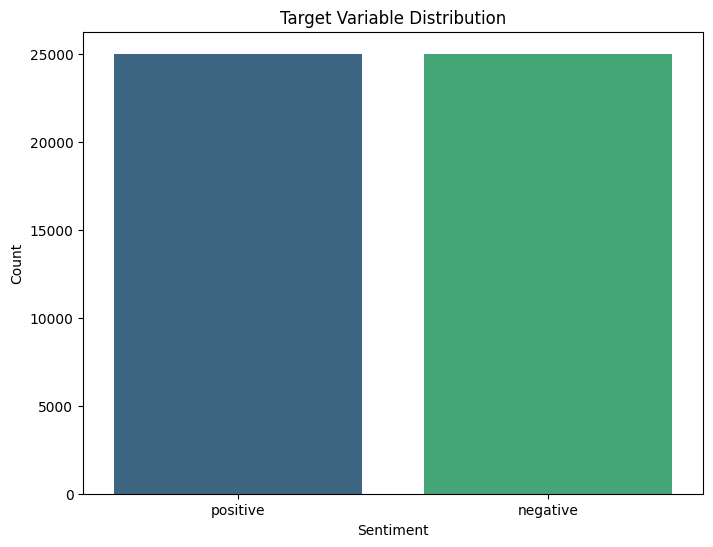

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=movies, palette = 'viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

##2.2 Data Preprocessing
 * Text preprocessing involves eliminating special characters/punctuations/white spaces/URLS, etc. and normalizing the text by transforming it to lowercase.
 * Applying lemmatization, which is collapsing forms of words such as loved/loving/lovely into love.
 * Eliminating english stop words such as 'and','the','is', etc. which might make the data noisy. But here's a catch, we remove custom stop words leaving behind the negation which can deprive the sentiment of the text.


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

# nltk.download('punkt') # Download necessary NLTK data for tokenization

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
movies['tokenized_review'] = movies['review'].apply(nltk.sent_tokenize)

In [ ]:
movies.head(5)

,review,sentiment,tokenized_review
0,One of the other reviewers has mentioned that ...,positive,[One of the other reviewers has mentioned that...
1,A wonderful little production. <br /><br />The...,positive,"[A wonderful little production., <br /><br />T..."
2,I thought this was a wonderful way to spend ti...,positive,[I thought this was a wonderful way to spend t...
3,Basically there's a family where a little boy ...,negative,[Basically there's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter Mattei's ""Love in the Time of Money"" i..."


In [ ]:
import re

def clean_text(text_list):
    cleaned_list = []
    for text in text_list:
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r"\W", " ", text) # Remove non-alphanumeric characters
            text = re.sub(r"\s+", " ", text) # Replace multiple spaces with a single space
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
            cleaned_list.append(text.strip()) # Remove leading/trailing whitespace
        else:
            cleaned_list.append(text) # If not string, append as-is
    return cleaned_list

movies['tags'] = movies['tokenized_review'].apply(clean_text)

In [ ]:
movies.head(5)

,review,sentiment,tokenized_review,tags
0,One of the other reviewers has mentioned that ...,positive,[One of the other reviewers has mentioned that...,[one of the other reviewers has mentioned that...
1,A wonderful little production. <br /><br />The...,positive,"[A wonderful little production., <br /><br />T...","[a wonderful little production, br br the film..."
2,I thought this was a wonderful way to spend ti...,positive,[I thought this was a wonderful way to spend t...,[i thought this was a wonderful way to spend t...
3,Basically there's a family where a little boy ...,negative,[Basically there's a family where a little boy...,[basically there s a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter Mattei's ""Love in the Time of Money"" i...",[petter mattei s love in the time of money is ...


In [ ]:
movies['tags'][0]

['one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked',
 'they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go',
 'trust me this is not a show for the faint hearted or timid',
 'this show pulls no punches with regards to drugs sex or violence',
 'its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary',
 'it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda',
 'em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away br br i would say the main appeal of the show is due to the fact that it goes wh

In [ ]:
from collections import Counter

# Take the raw column
raw_texts = movies['tags'].astype(str).tolist()

# Basic tokenization (just split on non-alphanumeric)
all_tokens = []
for text in raw_texts:
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)  # keep only alphanumeric words
    all_tokens.extend(tokens)

print("Total tokens:", len(all_tokens))
print("Unique terms:", len(set(all_tokens)))


Total tokens: 11976889
Unique terms: 101921


In [ ]:
# Use Counter to count
freq_dist = Counter(all_tokens)

# Top 20 terms
for word, count in freq_dist.most_common(50):
    print(word, ":", count)


the : 667993
and : 324441
a : 322979
of : 289410
to : 268124
is : 211082
br : 201951
it : 190857
in : 186781
i : 175633
this : 151002
that : 143879
s : 125008
was : 95608
as : 91750
movie : 87971
for : 87471
with : 87368
but : 83554
film : 79705
you : 69129
t : 68277
on : 68057
not : 60748
he : 58834
are : 58387
his : 57556
have : 55203
one : 53603
be : 53383
all : 46947
at : 46800
they : 45383
by : 44482
an : 42986
who : 42234
so : 40911
from : 40498
like : 40172
there : 37524
or : 35779
just : 35184
her : 34803
out : 34202
about : 34160
if : 33991
has : 33038
what : 32239
some : 31134
good : 29753


###Here, We see that the most frequent words are stop words. So we will be experimenting with eliminating stop words and applying lemmatizer.


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re # Import re for splitting words in the lemmatize function

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
# Keep negations
negations = {"not", "no", "nor", "never", "n't"}
custom_stopwords = stop_words - negations

lemmatizer = WordNetLemmatizer()

def lemmatize_sentences(sentence_list):
    lemmatized_sentences = []
    for sentence in sentence_list:
        lemmatized_words = []
        # Split the sentence into words using re.findall to handle potential multiple spaces
        for word in re.findall(r'\b\w+\b', sentence):
            if word not in custom_stopwords:
                lemmatized_words.append(lemmatizer.lemmatize(word))
        lemmatized_sentences.append(" ".join(lemmatized_words))
    return lemmatized_sentences


movies['lemmatized_reviews'] = movies['tags'].apply(lemmatize_sentences)

In [ ]:
movies.head(5)

,review,sentiment,tokenized_review,tags,lemmatized_reviews
0,One of the other reviewers has mentioned that ...,positive,[One of the other reviewers has mentioned that...,[one of the other reviewers has mentioned that...,[one reviewer mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,"[A wonderful little production., <br /><br />T...","[a wonderful little production, br br the film...","[wonderful little production, br br filming te..."
2,I thought this was a wonderful way to spend ti...,positive,[I thought this was a wonderful way to spend t...,[i thought this was a wonderful way to spend t...,[thought wonderful way spend time hot summer w...
3,Basically there's a family where a little boy ...,negative,[Basically there's a family where a little boy...,[basically there s a family where a little boy...,[basically family little boy jake think zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter Mattei's ""Love in the Time of Money"" i...",[petter mattei s love in the time of money is ...,[petter mattei love time money visually stunni...


In [ ]:
movies['lemmatized_reviews'][0]

['one reviewer mentioned watching 1 oz episode hooked',
 'right exactly happened br br first thing struck oz brutality unflinching scene violence set right word go',
 'trust not show faint hearted timid',
 'show pull no punch regard drug sex violence',
 'hardcore classic use word br br called oz nickname given oswald maximum security state penitentary',
 'focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda',
 'em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away br br would say main appeal show due fact go show dare',
 'forget pretty picture painted mainstream audience forget charm forget romance oz mess around',
 'first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence',
 'not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate t

In [ ]:
from collections import Counter

# Take the raw column
lemmatized_texts = movies['lemmatized_reviews'].astype(str).tolist()

# Basic tokenization (just split on non-alphanumeric)
all_tokens = []
for text in raw_texts:
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)  # keep only alphanumeric words
    all_tokens.extend(tokens)

print("Total tokens:", len(all_tokens))
print("Unique terms:", len(set(all_tokens)))


Total tokens: 11976889
Unique terms: 101921


In [ ]:
# Use Counter to count
freq_dist = Counter(all_tokens)

# Top 20 terms
for word, count in freq_dist.most_common(50):
    print(word, ":", count)


the : 667993
and : 324441
a : 322979
of : 289410
to : 268124
is : 211082
br : 201951
it : 190857
in : 186781
i : 175633
this : 151002
that : 143879
s : 125008
was : 95608
as : 91750
movie : 87971
for : 87471
with : 87368
but : 83554
film : 79705
you : 69129
t : 68277
on : 68057
not : 60748
he : 58834
are : 58387
his : 57556
have : 55203
one : 53603
be : 53383
all : 46947
at : 46800
they : 45383
by : 44482
an : 42986
who : 42234
so : 40911
from : 40498
like : 40172
there : 37524
or : 35779
just : 35184
her : 34803
out : 34202
about : 34160
if : 33991
has : 33038
what : 32239
some : 31134
good : 29753


###Here, The word 'br' comes from the HTML tags, so considering that it has no relevance to sentiment and is the top most frequent word as of now, we can drop the words.

In [ ]:
import re

def remove_br(text):
    clean_text = []
    for sentence in text:
        clean_text.append(re.sub(r'\bbr\b', '', sentence).strip())
        # Remove isolated 'br' tokens (word boundary ensures it doesn't cut words like 'bright')
    return clean_text

movies['lemmatized_reviews'] = movies['lemmatized_reviews'].apply(remove_br)



In [ ]:
movies['lemmatized_reviews'][0]

['one reviewer mentioned watching 1 oz episode hooked',
 'right exactly happened   first thing struck oz brutality unflinching scene violence set right word go',
 'trust not show faint hearted timid',
 'show pull no punch regard drug sex violence',
 'hardcore classic use word   called oz nickname given oswald maximum security state penitentary',
 'focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda',
 'em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away   would say main appeal show due fact go show dare',
 'forget pretty picture painted mainstream audience forget charm forget romance oz mess around',
 'first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence',
 'not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison

##2.3 Visualising the difference in vocabulary before and after removing stop words and lemmatising

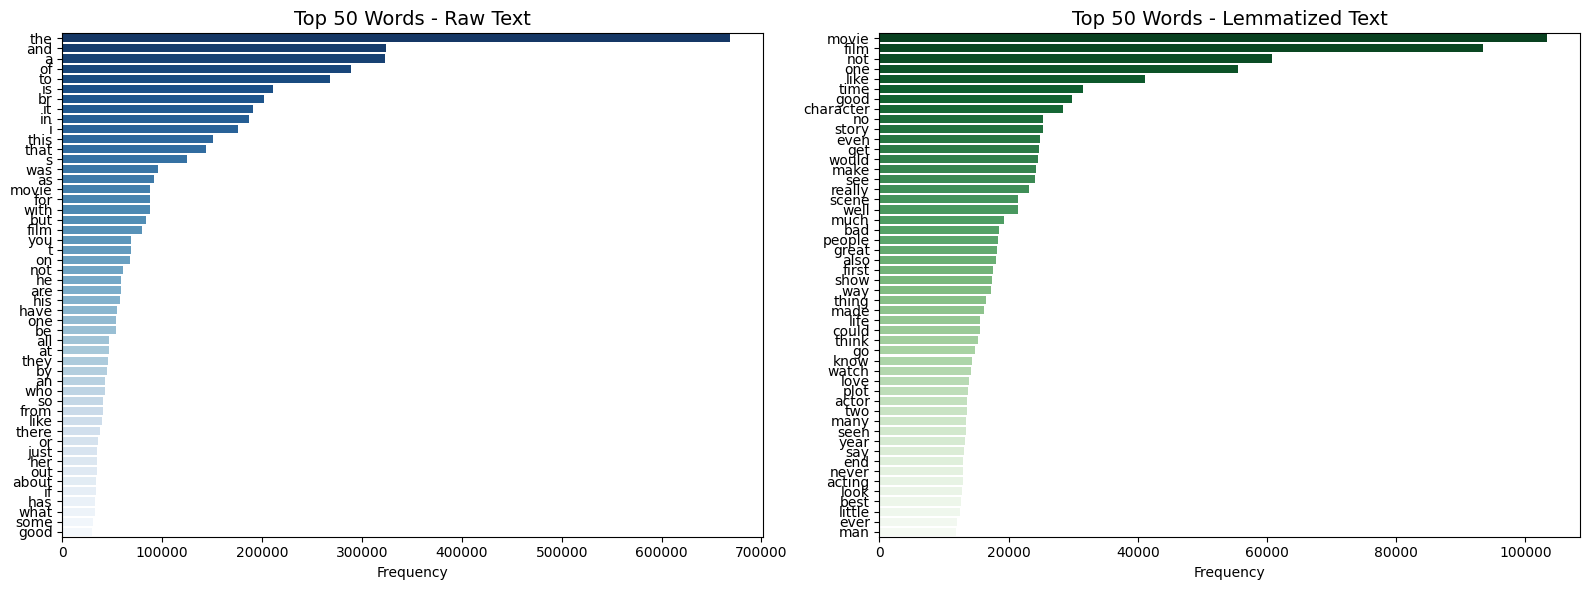

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

def get_top_tokens(texts, n=50):
    tokens = []
    for text in texts.astype(str):
        text = text.lower()
        tokens.extend(re.findall(r"\b\w+\b", text))
    return Counter(tokens).most_common(n)

# Top 50 raw vs lemmatized
raw_top = get_top_tokens(movies['tags'], n=50)
lemm_top = get_top_tokens(movies['lemmatized_reviews'], n=50)

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.barplot(x=[c for w,c in raw_top], y=[w for w,c in raw_top], ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 50 Words - Raw Text", fontsize=14)
axes[0].set_xlabel("Frequency")

sns.barplot(x=[c for w,c in lemm_top], y=[w for w,c in lemm_top], ax=axes[1], palette="Greens_r")
axes[1].set_title("Top 50 Words - Lemmatized Text", fontsize=14)
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()


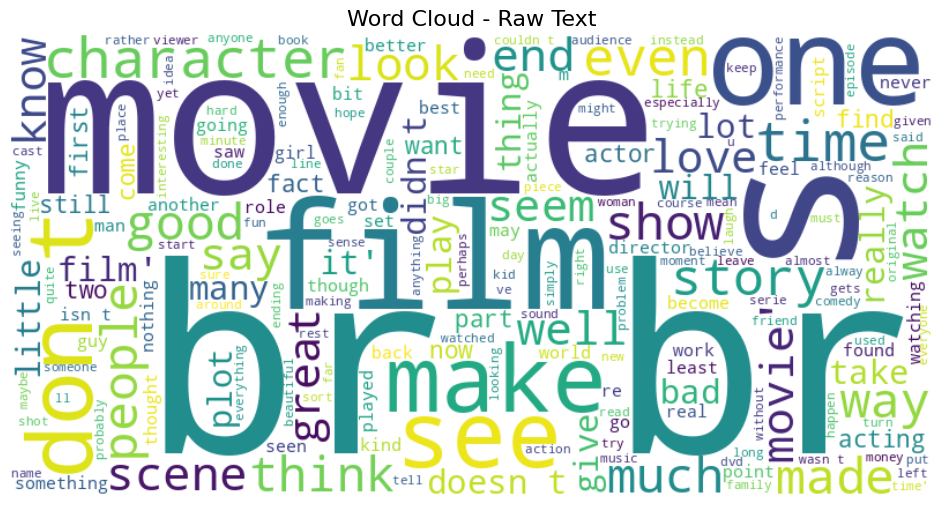

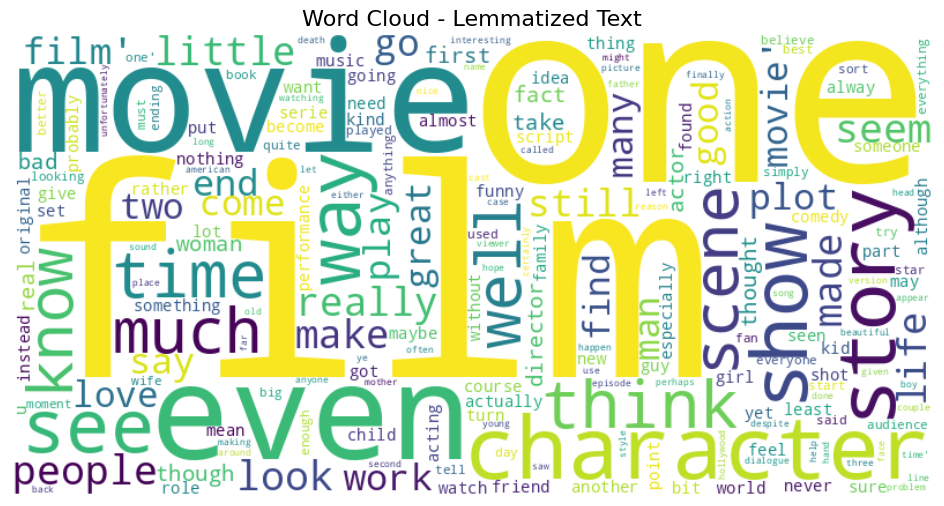

In [ ]:
from wordcloud import WordCloud

# Raw tokens
raw_tokens = " ".join(movies['tags'].astype(str))
lemm_tokens = " ".join(movies['lemmatized_reviews'].astype(str))

# Word Cloud - Raw
raw_wc = WordCloud(width=800, height=400, background_color="white").generate(raw_tokens)
plt.figure(figsize=(12,6))
plt.imshow(raw_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Raw Text", fontsize=16)
plt.show()

# Word Cloud - Lemmatized
lemm_wc = WordCloud(width=800, height=400, background_color="white").generate(lemm_tokens)
plt.figure(figsize=(12,6))
plt.imshow(lemm_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Lemmatized Text", fontsize=16)
plt.show()


##Insights from the visualization:
  -> Vocabulary Reduction Insights

  * Before preprocessing (raw text):

* Total tokens: 11,976,889

* Unique terms: 101,921

* After stopword removal + lemmatization:

* Total tokens: 6,268,734

* Unique terms: 92,304

-> Interpretation

* Token count reduced by ~48% → showing that common, non-informative words (like the, is, at) were successfully removed.

* Unique vocabulary reduced by ~9% → redundant variants (running → run, movies → movie) were consolidated through lemmatization.

* The processed dataset is now cleaner, denser, and semantically richer, helping the model focus on sentiment-bearing words (e.g., good, bad, boring, excellent) rather than noise.

-> This shows preprocessing not only shrinks the dataset size, making training faster, but also improves signal-to-noise ratio, which should lead to better generalization.

##3. Experimenting various models
Experimenting the following models and parameters to evaluate the best model based on accuracy metrics such as Accuracy score, F1 score and precision
  * BoW+ Logistic Regression
  * Tf-idf + LR
  * Tf-idf + RNN
  * Embedding layer+ RNN
  * Embedding + LSTM
  * Embedding + Bidir Lstm
  * Embedding + GRU


In [ ]:
import numpy as np, pandas as pd, random, os
from sklearn.model_selection import train_test_split
RND = 42

# Example: df with 'lemmatized_reviews' (string) and 'label' (0/1)
df = movies[['lemmatized_reviews','sentiment']].dropna().copy()
df['text'] = df['lemmatized_reviews'].astype(str)    # ensure strings

train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['sentiment'], random_state=RND)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['sentiment'], random_state=RND)
print(len(train_df), len(valid_df), len(test_df))


35000 7500 7500


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35000 entries, 27509 to 27491
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   lemmatized_reviews  35000 non-null  object
 1   sentiment           35000 non-null  object
 2   text                35000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [ ]:
def set_seed(seed=42):
    import numpy as _np, random as _random, tensorflow as _tf
    _random.seed(seed)
    _np.random.seed(seed)
    try:
        _tf.random.set_seed(seed)
    except Exception:
        pass

set_seed(RND)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 50000
Max_len = 300

token = Tokenizer(num_words=MAX_VOCAB, oov_token='<unk>')
token.fit_on_texts(train_df['text'])
X_train_vec = token.texts_to_sequences(train_df['text'])
X_val_vec = token.texts_to_sequences(valid_df['text'])
X_train = pad_sequences(X_train_vec, maxlen=Max_len, padding='post', truncating='post')
X_val = pad_sequences(X_val_vec, maxlen=Max_len, padding='post', truncating='post')
y_train = train_df['sentiment'].values
y_val = valid_df['sentiment'].values
vocab_size = min(MAX_VOCAB, len(token.word_index)+1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers, models

results = []

# ---------- Utility ----------
def evaluate_and_log(y_true, y_pred, model_name, start):
    end = time.time()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    results.append({
        'model': model_name,
        'acc': acc,
        'f1': f1,
        'time_min': round((end - start) / 60, 2)
    })

# ---------- Classical ML ----------
def run_logistic_regression(X_train_text, y_train, X_val_text, y_val, vectorizer, model_name):
    start = time.time()
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_val_vec = vectorizer.transform(X_val_text)

    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_val_vec)

    evaluate_and_log(y_val, y_pred, model_name, start)

# ---------- Neural Models ----------
def build_rnn(vocab_size, emb_dim=128, rnn_units=64, bidir=False):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, emb_dim, input_length=Max_len))
    if bidir:
        model.add(layers.Bidirectional(layers.LSTM(rnn_units)))
    else:
        model.add(layers.SimpleRNN(rnn_units))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def build_lstm(vocab_size, emb_dim=128, rnn_units=128, bidir=False):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, emb_dim, input_length= Max_len))
    if bidir:
        model.add(layers.Bidirectional(layers.LSTM(rnn_units)))
    else:
        model.add(layers.LSTM(rnn_units))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def build_gru(vocab_size, emb_dim=128, rnn_units=64):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, emb_dim, input_length=Max_len))
    model.add(layers.GRU(rnn_units))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def run_keras_model(model_fn, model_name, X_train, y_train, X_val, y_val, epochs=8, batch_size=128):
    start = time.time()
    model = model_fn()
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=0, callbacks = [es])

    y_pred = (model.predict(X_val) >= 0.5).astype(int).ravel()
    evaluate_and_log(y_val, y_pred, model_name, start)

# ---------- Transformer (e.g., DistilBERT) ----------
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

def run_transformer(model_name, X_train, y_train, X_val, y_val, model_ckpt="distilbert-base-uncased", epochs=2):
    start = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Tokenize
    train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors="tf")
    val_enc = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors="tf")

    # Build model
    transformer_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
    transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                              metrics=["accuracy"])

    transformer_model.fit(train_enc, y_train, validation_data=(val_enc, y_val), epochs=epochs, batch_size=16, verbose=0)

    y_pred = np.argmax(transformer_model.predict(val_enc).logits, axis=1)
    evaluate_and_log(y_val, y_pred, model_name, start)

# ---------- Master Runner ----------
def run_all_experiments(X_train_text, X_val_text, X_val, y_val, X_train, y_train, vocab_size, Max_len):
    # Ensure text is in string format for vectorizers
    X_train_flat = [" ".join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_train_text]
    X_val_flat = [" ".join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_val_text]

    # 1. Bag of Words + LR
    run_logistic_regression(X_train_flat, y_train, X_val_flat, y_val, CountVectorizer(max_features=10000), "LR_BoW")

    # 2. TF-IDF + LR
    run_logistic_regression(X_train_flat, y_train, X_val_flat, y_val, TfidfVectorizer(max_features=10000), "LR_TFIDF")

    # 3. TF-IDF + Simple RNN baseline (actually dense LR with TF-IDF)
    run_logistic_regression(X_train_flat, y_train, X_val_flat, y_val, TfidfVectorizer(max_features=10000), "TFIDF_RNN_baseline")

    # 4. Embedding + Simple RNN
    run_keras_model(lambda: build_rnn(vocab_size), "Embedding+RNN", X_train, y_train, X_val, y_val)

    # 5. Embedding + LSTM
    run_keras_model(lambda: build_lstm(vocab_size), "Embedding+LSTM", X_train, y_train, X_val, y_val)

    # 6. Embedding + GRU
    run_keras_model(lambda: build_gru(vocab_size), "Embedding+GRU", X_train, y_train, X_val, y_val)

    # 7. Embedding + BiLSTM
    run_keras_model(lambda: build_lstm(vocab_size, bidir=True), "Embedding+BiLSTM", X_train, y_train, X_val, y_val)

    # Final comparison
    df = pd.DataFrame(results).sort_values("f1", ascending=False)
    return df


##4. Visualization of the result of the experiment

In [ ]:
results_df = run_all_experiments(train_df['lemmatized_reviews'],valid_df['lemmatized_reviews'], X_val, y_val,X_train, y_train, vocab_size, Max_len)
print(results_df)

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step
                model       acc        f1  time_min
1            LR_TFIDF  0.887867  0.887859      0.06
2  TFIDF_RNN_baseline  0.887867  0.887859      0.06
6    Embedding+BiLSTM  0.875333  0.875247     21.75
0              LR_BoW  0.872800  0.872800      0.11
3       Embedding+RNN  0.497733  0.497731      2.15
5       Embedding+GRU  0.499867  0.336330      7.25
4      Embedding+LSTM  0.500133  0.333866     10.82


Text(0.5, 1.0, 'Comparison of Models by Accuracy Score')

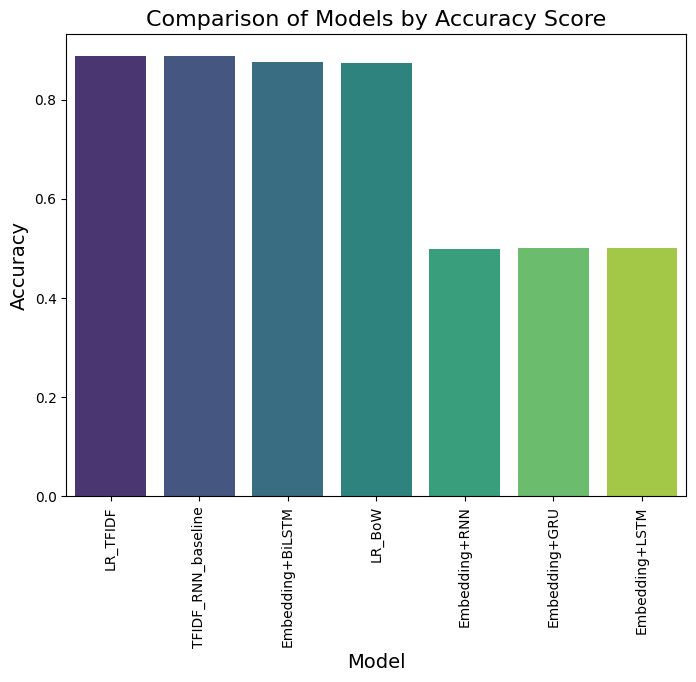

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='model', y='acc', data=results_df, palette='viridis')
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation='vertical')
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Models by Accuracy Score', fontsize=16)

In [ ]:
# 1. Download GloVe (if not already downloaded)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove.6B

# 2. Build Embedding Matrix
import numpy as np

def build_embedding_matrix(word_index, embedding_dim, glove_path, max_vocab=50000):
    embeddings_index = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector

    print(f"Loaded {len(embeddings_index)} word vectors from GloVe")

    vocab_size = min(max_vocab, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in word_index.items():
        if idx < vocab_size:
            vector = embeddings_index.get(word)
            if vector is not None:
                embedding_matrix[idx] = vector

    return embedding_matrix, vocab_size

embedding_dim = 100
glove_path = "glove.6B/glove.6B.100d.txt"
embedding_matrix, vocab_size = build_embedding_matrix(token.word_index, embedding_dim, glove_path, MAX_VOCAB)

# 3. Define Pretrained LSTM
from tensorflow.keras import layers, models
import tensorflow as tf

def pretrained_lstm():
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim,
                               weights=[embedding_matrix],
                               input_length=Max_len,
                               trainable=False))   # keep embeddings frozen
    model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# 4. Train with Validation
model = pretrained_lstm()

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

# 5. Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f}")

# 6. Extra: F1 score
from sklearn.metrics import f1_score

y_pred = (model.predict(X_val) >= 0.5).astype(int).ravel()
val_f1 = f1_score(y_val, y_pred, average="macro")
print(f"Validation F1 Score: {val_f1:.4f}")


--2025-09-10 00:14:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-10 00:14:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-10 00:14:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

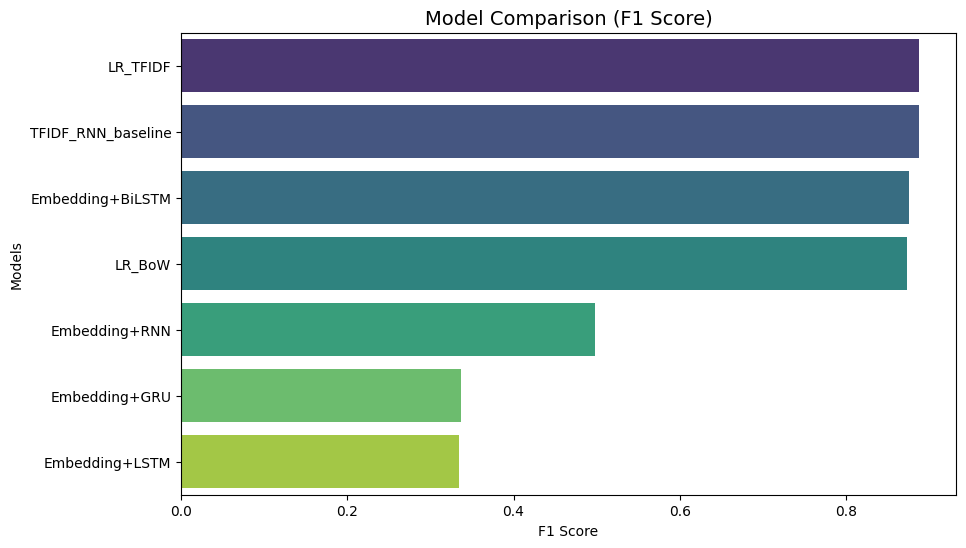

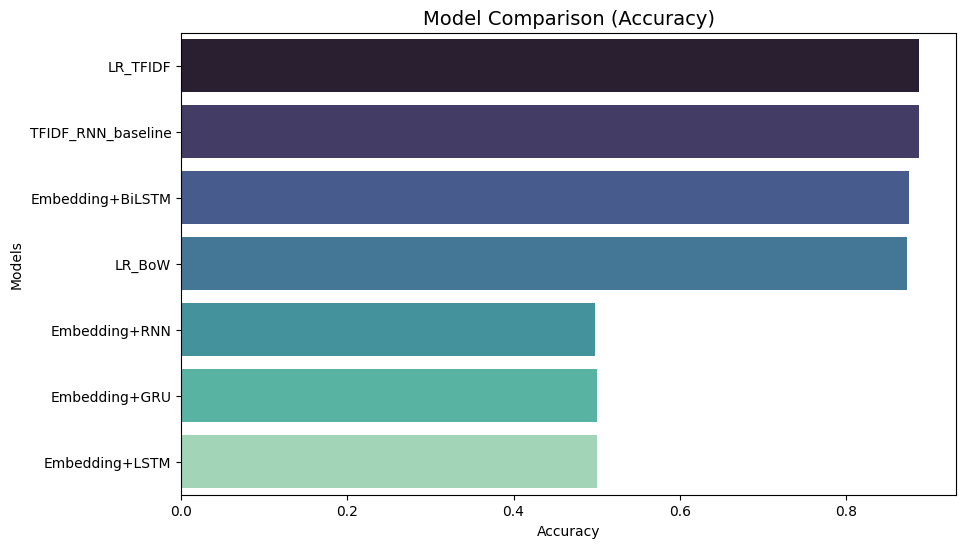

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="f1", y="model", palette="viridis")
plt.title("Model Comparison (F1 Score)", fontsize=14)
plt.xlabel("F1 Score")
plt.ylabel("Models")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="acc", y="model", palette="mako")
plt.title("Model Comparison (Accuracy)", fontsize=14)
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.show()


[link text](https://)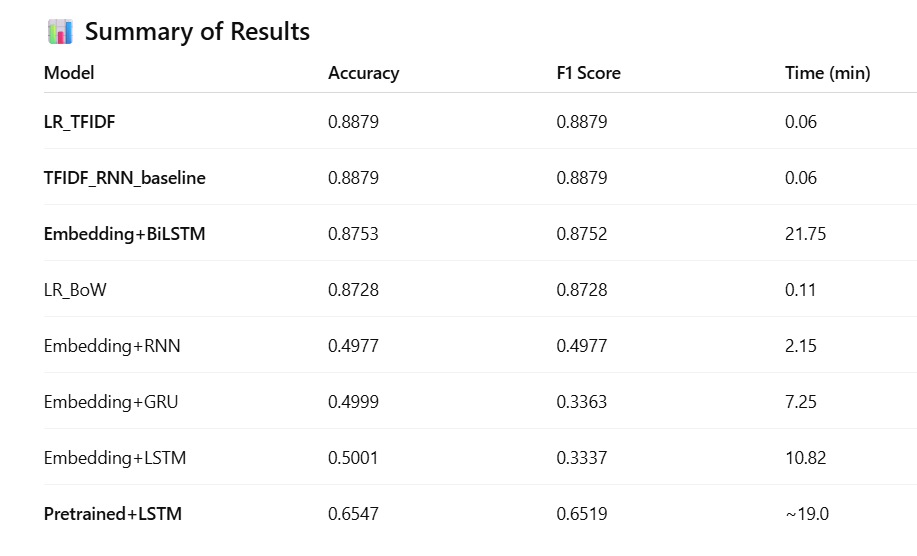

##Summary
1. Classical models (TF-IDF + Logistic Regression) dominated

LR_TFIDF and TFIDF_RNN_baseline achieved ~0.887 F1, which is the highest across all experiments.

These models are simple, fast (under a minute), and effective for text classification.

Bag of Words baseline is strong

Even a BoW + LR model reached 0.872 F1, not far behind TF-IDF.

Suggests that feature richness (TF-IDF weighting) improves but isn’t drastically different from raw counts.

2. Vanilla embedding + RNN/LSTM/GRU underperformed badly

These models hovered around 0.33–0.49 F1 (close to random guessing for binary classification).

Likely reasons:

Not enough epochs or hyperparameter tuning.

Random embeddings without pretrained initialization → poor semantic representation.

Possibly vanishing gradients for RNNs on long reviews.

3. Pretrained embeddings improved neural model performance

Pretrained LSTM jumped to 0.65 F1, far better than random embeddings (0.33–0.50).

However, still far behind classical TF-IDF + LR (0.887).

Indicates pretrained embeddings help capture semantics, but training may need:

Fine-tuning embeddings,

More layers or attention,

Regularization (dropout, batch norm).

4. BiLSTM with learned embeddings performed best among neural networks

Accuracy/F1 ~0.875, quite close to TF-IDF + LR.

Shows that bidirectional context improves representation.

However, training time was 21 minutes vs <1 minute for logistic regression.

#Trade-Off Analysis
1. Performance vs Complexity

Logistic Regression with TF-IDF:

Simple, interpretable, lightweight.

Highest performance (~0.887 F1).

Deep learning (BiLSTM, pretrained LSTM):

Heavier, more complex, less interpretable.

Comparable or worse performance (0.65–0.87).

2. Training Time vs Gains

Logistic Regression trains in seconds and gives near-SOTA results for sentiment.

BiLSTM/Pretrained embeddings took 20x more time for equal or worse accuracy.

3. Generalization vs Domain Adaptation

Classical models: good for “bag of words” style tasks like movie reviews.

Neural models: may generalize better when texts are longer, more complex, or multilingual (but require more tuning and data).

4. Scalability

Logistic Regression scales well to large datasets without GPUs.

RNN/LSTM/GRU require GPUs, careful hyperparameter tuning, and longer time.